In [1]:
library('tidymodels')

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ recipes      1.0.9
✔ dials        1.2.0     ✔ rsample      1.2.0
✔ dplyr        1.1.4     ✔ tibble       3.2.1
✔ ggplot2      3.4.4     ✔ tidyr        1.3.1
✔ infer        1.0.5     ✔ tune         1.1.2
✔ modeldata    1.3.0     ✔ workflows    1.1.3
✔ parsnip      1.1.1     ✔ workflowsets 1.0.1
✔ purrr        1.0.2     ✔ yardstick    1.3.0

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Use tidymodels_prefer() to resolve common conflicts.



In [2]:
ames |> head()

MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,⋯,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude
<fct>,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<int>,<dbl>,<dbl>
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,⋯,No_Fence,None,0,5,2010,WD,Normal,215000,-93.61975,42.05403
One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,⋯,Minimum_Privacy,None,0,6,2010,WD,Normal,105000,-93.61976,42.05301
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,⋯,No_Fence,Gar2,12500,6,2010,WD,Normal,172000,-93.61939,42.05266
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,⋯,No_Fence,None,0,4,2010,WD,Normal,244000,-93.61732,42.05125
Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,⋯,Minimum_Privacy,None,0,3,2010,WD,Normal,189900,-93.63893,42.06090
Two_Story_1946_and_Newer,Residential_Low_Density,78,9978,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,⋯,No_Fence,None,0,6,2010,WD,Normal,195500,-93.63893,42.06078


`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


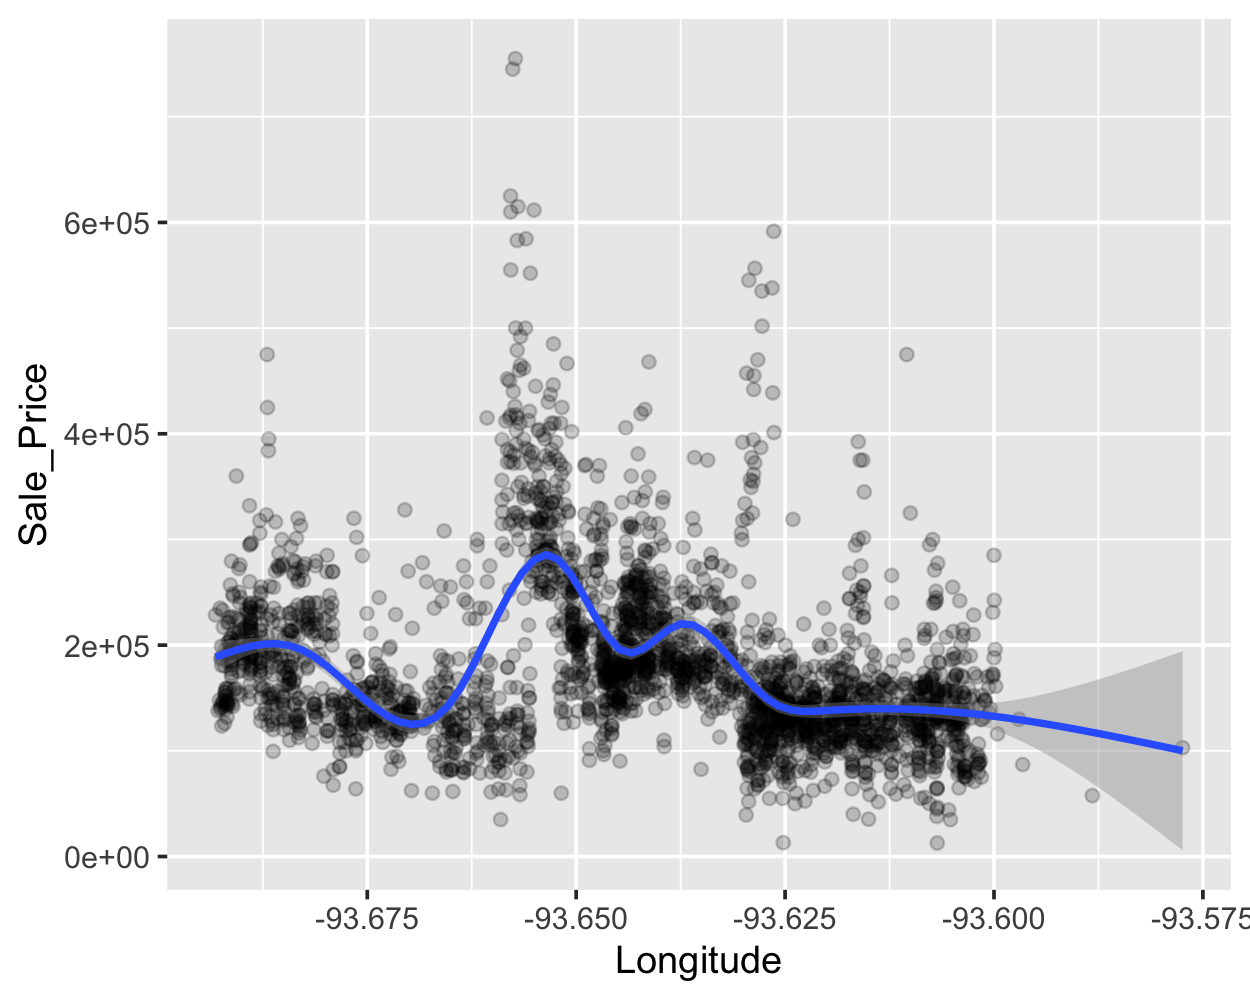

In [3]:
ggplot(ames, aes(x = Longitude, y = Sale_Price)) + 
    geom_point(alpha = 0.2) +
    stat_smooth()

`geom_smooth()` using formula = 'y ~ x'


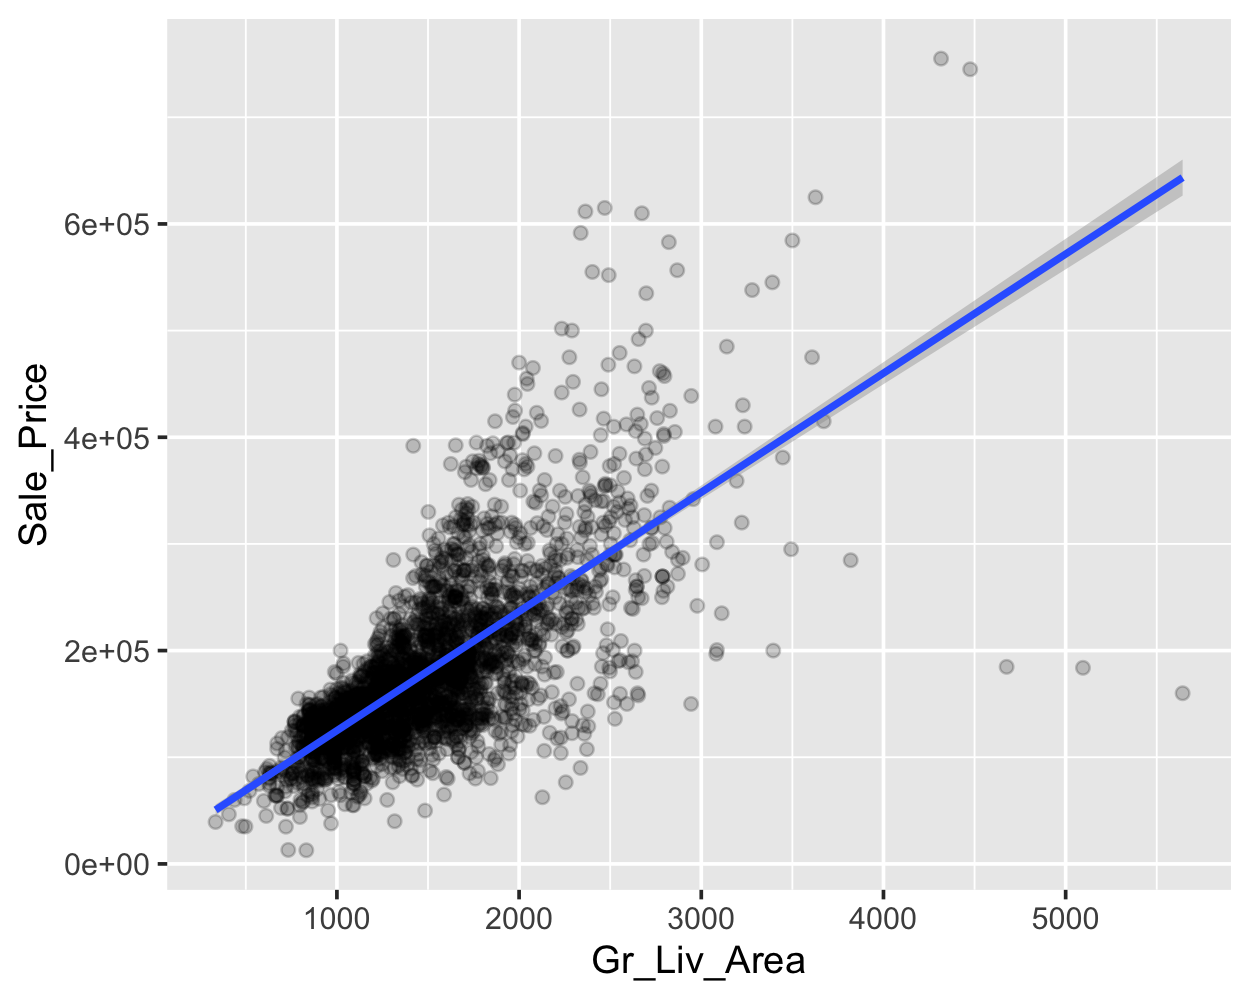

In [4]:
ggplot(ames, aes(x = Gr_Liv_Area, y = Sale_Price)) + 
    geom_point(alpha = 0.2) +
    stat_smooth(method = 'lm')

In [5]:
folds = vfold_cv(ames, v = 10)

folds |> glimpse()

Rows: 10
Columns: 2
$ splits <list> [<vfold_split[2637 x 293 x 2930 x 74]>], [<vfold_split[2637 x …
$ id     <chr> "Fold01", "Fold02", "Fold03", "Fold04", "Fold05", "Fold06", "Fo…


In [6]:
rec = recipe(Sale_Price ~ Gr_Liv_Area + Longitude + Latitude, data = ames) |>
    step_ns(Latitude, deg_free = tune('lat_df')) |>
    step_ns(Longitude, deg_free = tune('lon_df'))

mod = linear_reg() |> set_engine('lm')

In [7]:
deg_free_table = expand.grid(lon_df = 2:16, lat_df = 2:16)

deg_free_table |> head()

,lon_df,lat_df
,<int>,<int>
1,2,2
2,3,2
3,4,2
4,5,2
5,6,2
6,7,2


In [8]:
# This takes a bit to run!

mod_res = tune_grid(mod, rec, resamples = folds, grid = deg_free_table)

In [9]:
mod_res |> 
    collect_metrics() |>
    head()

lat_df,lon_df,.metric,.estimator,mean,n,std_err,.config
<int>,<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,2,rmse,standard,4.770822e+04,10,1.321829e+03,Preprocessor001_Model1
2,2,rsq,standard,6.412971e-01,10,1.386475e-02,Preprocessor001_Model1
2,3,rmse,standard,4.767226e+04,10,1.267836e+03,Preprocessor002_Model1
2,3,rsq,standard,6.415856e-01,10,1.407596e-02,Preprocessor002_Model1
2,4,rmse,standard,4.770486e+04,10,1.273331e+03,Preprocessor003_Model1
2,4,rsq,standard,6.411383e-01,10,1.408960e-02,Preprocessor003_Model1


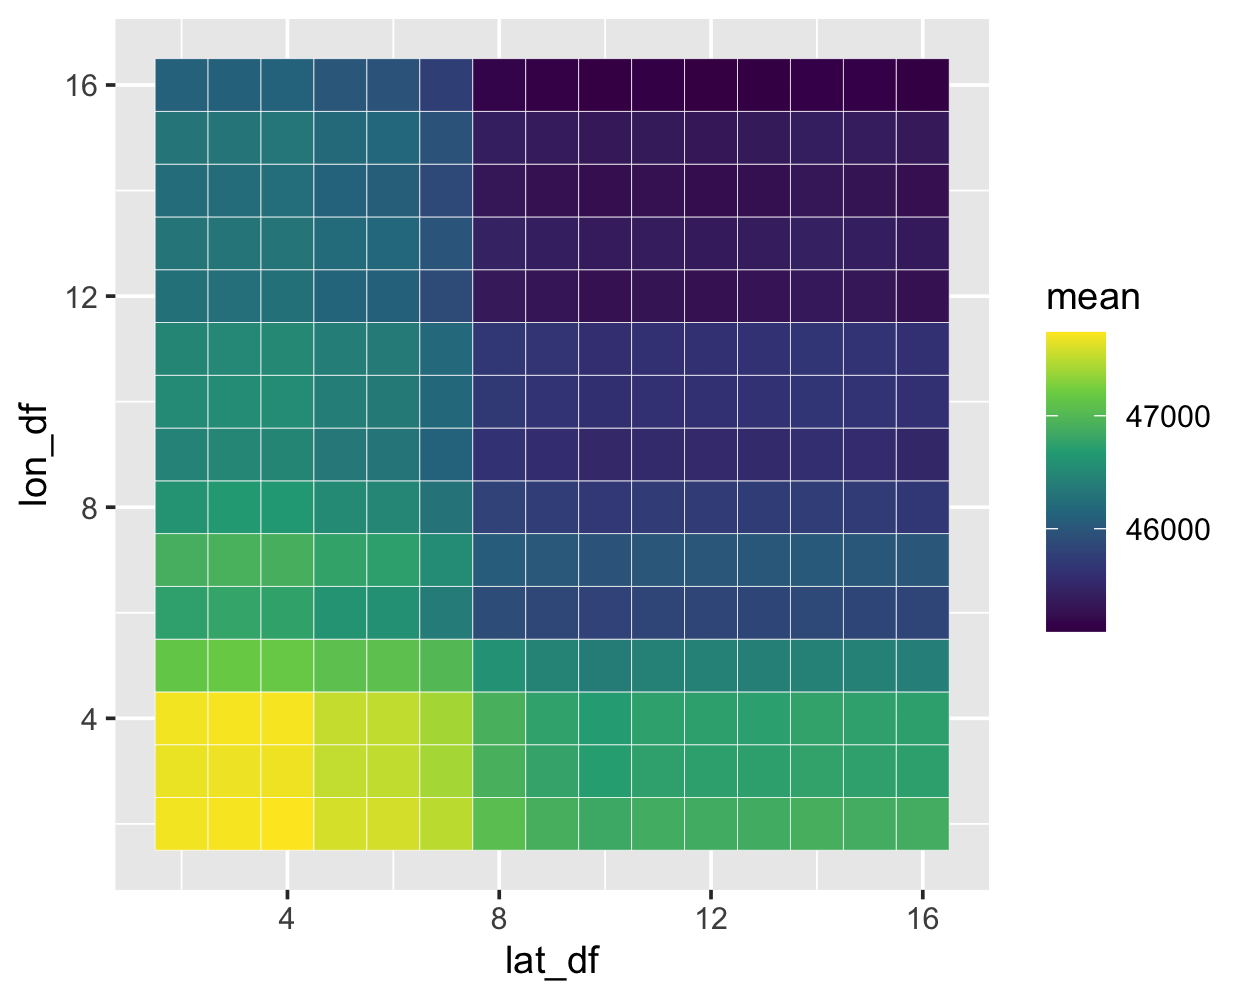

In [10]:
options(repr.plot.width = 5)

mod_res |> 
    collect_metrics() |>
    filter(.metric == 'rmse') |>
ggplot(aes(x = lat_df, y = lon_df, fill = mean)) +
    geom_tile(color = 'white') +
    scale_fill_viridis_c()

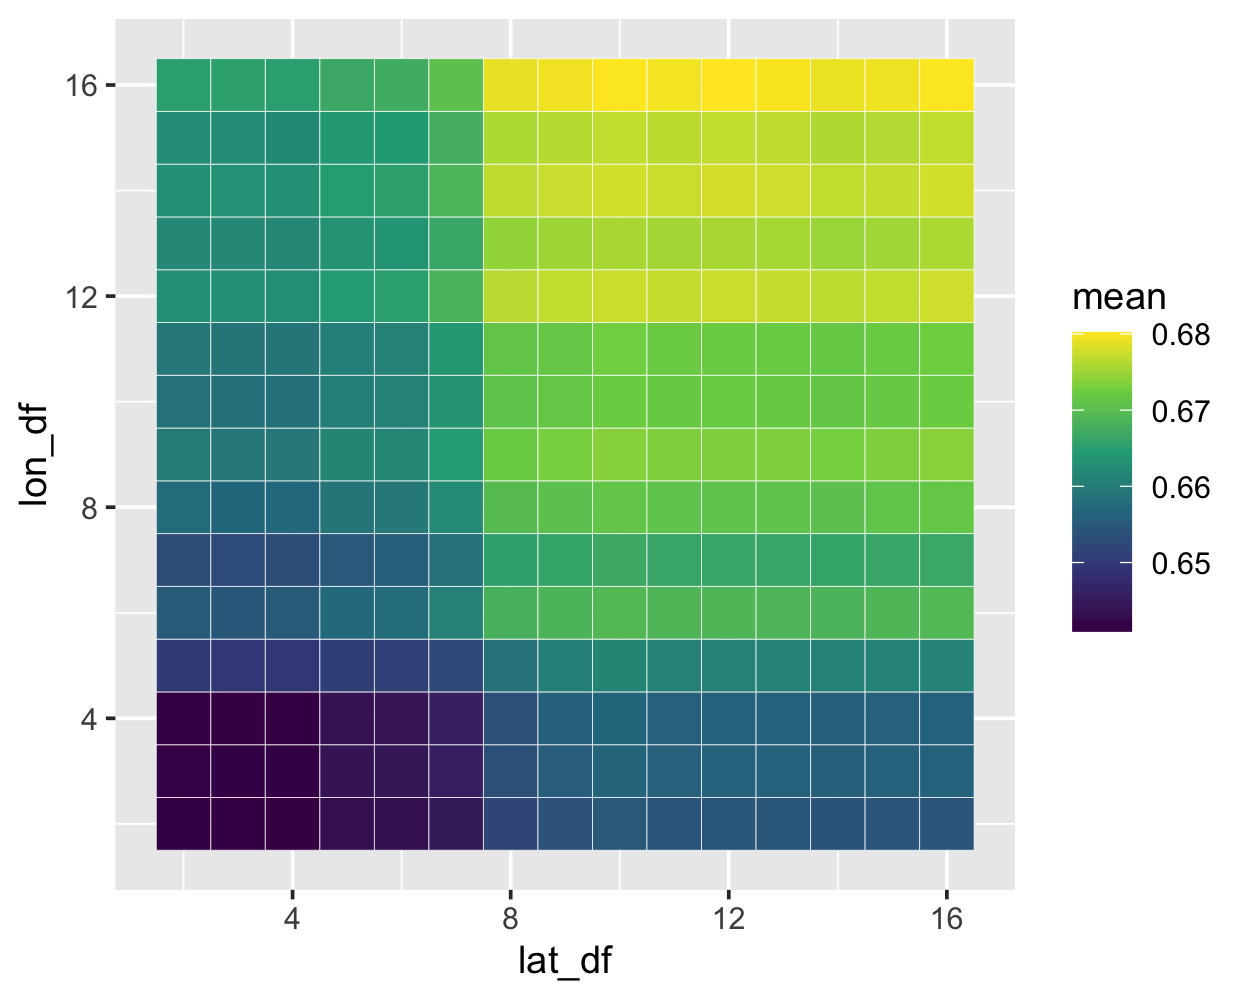

In [11]:
mod_res |> 
    collect_metrics() |>
    filter(.metric == 'rsq') |>
ggplot(aes(x = lat_df, y = lon_df, fill = mean)) +
    geom_tile(color = 'white') +
    scale_fill_viridis_c()

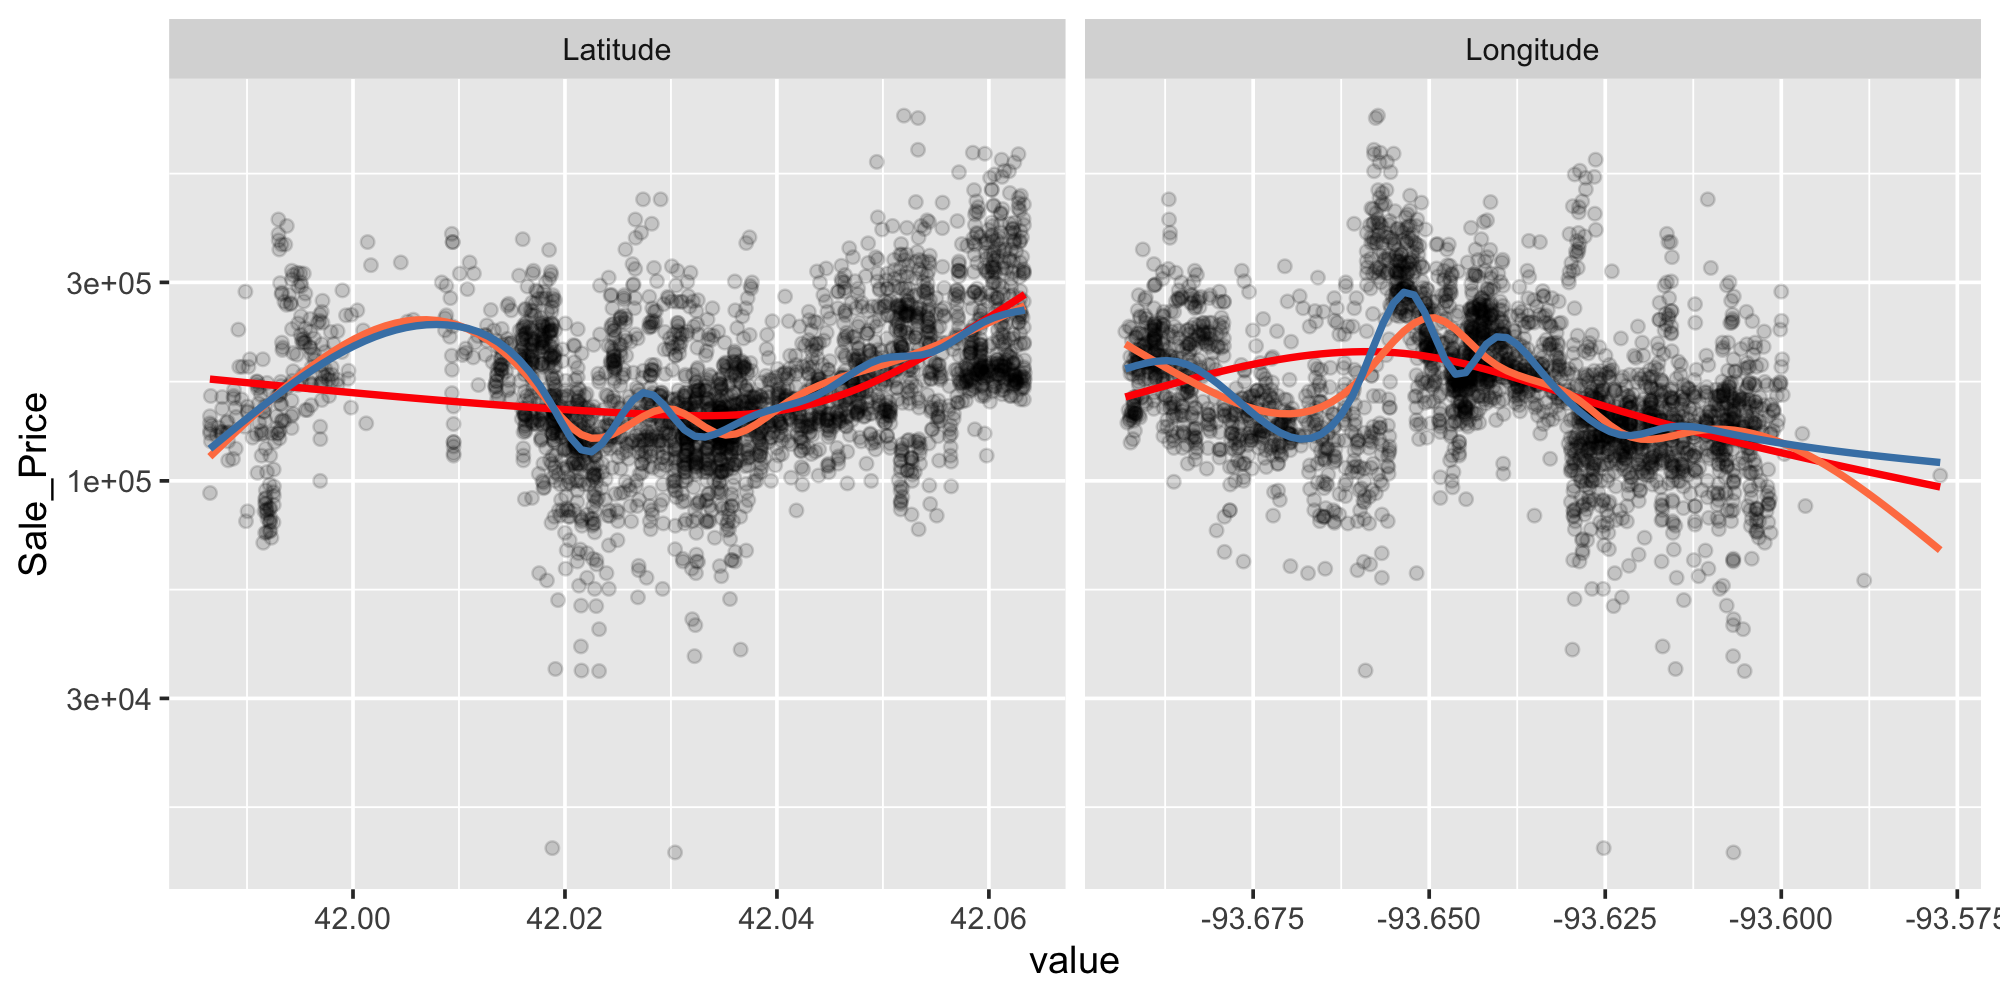

In [12]:
options(repr.plot.width = 8)

ames |>
  dplyr::select(Sale_Price, Longitude, Latitude) |> 
  tidyr::pivot_longer(cols = c(Longitude, Latitude), 
                      names_to = "predictor", values_to = "value") |>
  ggplot(aes(x = value, Sale_Price)) + 
  geom_point(alpha = .15) + 
  geom_smooth(se = FALSE, method = lm, formula = y ~ splines::ns(x, df = 3),  col = "red")  + 
  geom_smooth(se = FALSE, method = lm, formula = y ~ splines::ns(x, df = 8),  col = "coral") +
  geom_smooth(se = FALSE, method = lm, formula = y ~ splines::ns(x, df = 12), col = 'steelblue') +
  scale_y_log10() +
  facet_wrap(~ predictor, scales = "free_x")